In [1]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20,8))

In [2]:
import gmsh 
import numpy as np

gmsh.initialize()    # esto es como abrir un programa 
gmsh.model.add('testeo') #creo el modelo que modificare
lc=1
L=10
p1=gmsh.model.geo.addPoint(0,0,0,lc)
p2=gmsh.model.geo.addPoint(2*L,0,0,lc)
p3=gmsh.model.geo.addPoint(2*L,L,0,lc)
p4=gmsh.model.geo.addPoint(0,L,0,lc)
l1=gmsh.model.geo.addLine(p1,p2)
l2=gmsh.model.geo.addLine(p2,p3)
l3=gmsh.model.geo.addLine(p3,p4)
l4=gmsh.model.geo.addLine(p4,p1)
c1=gmsh.model.geo.addCurveLoop([l1,l2,l3,l4])
s1=gmsh.model.geo.addPlaneSurface([c1])
gmsh.model.geo.synchronize()

Empotrado=gmsh.model.addPhysicalGroup(1,[l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')

Traccionado=gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[s1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')


gmsh.model.mesh.generate(2)


NodeInfo = gmsh.model.mesh.get_nodes()
NumeroNodos=NodeInfo[0].shape[0]

MN=NodeInfo[1].reshape(NumeroNodos,3)

ETAGS,ELEMENTS=gmsh.model.mesh.get_elements_by_type(2)

MC=ELEMENTS.reshape([ETAGS.shape[0],3])

MC=(MC-1).astype(int) # etiquetas de los nodos con notacion python


NodosEmpotrados=gmsh.model.mesh.get_nodes_for_physical_group(1,Empotrado)
CE=NodosEmpotrados[1].reshape(NodosEmpotrados[0].shape[0],3) # son las coordenadas.

s=NodosEmpotrados[0].reshape(len(NodosEmpotrados[0]),1) # etiquetas de los nodos empotrados
z=np.zeros([len(NodosEmpotrados[0]),2])
MNE=np.concatenate((s-1,z),axis=1)  # etiquetas de los nodos con notacion python
MNE=MNE.astype(int)


NodosTraccionados=gmsh.model.mesh.get_nodes_for_physical_group(1,Traccionado)

# MDF_comment por qué guardas todos los ceros ?
s=NodosTraccionados[0].reshape(len(NodosTraccionados[0]),1).astype(int) # etiquetas de los nodos traccionados
z=np.zeros([len(NodosTraccionados[0]),2]).astype(int)
MNT=np.concatenate((s-1,z),axis=1) # etiquetas de los nodos con notacion python


# encuentro las fuerzas ejercidas en cada nodo del extremo empotrado
entityTraccionada=gmsh.model.getEntitiesForPhysicalGroup(1,Traccionado)
Tgroup,Ttraccionada,Ltraccionada=gmsh.model.mesh.getElements(1,entityTraccionada[0])
Ltraccionada=Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2) #es la matriz de conectividad de los elementos linea del extremo traccionado 
Longitudes=np.abs(MN[Ltraccionada[:,0]-1,1]-MN[Ltraccionada[:,1]-1,1])

t=1 #[inch]
Tension_ext=10000/L

for l,linea in enumerate(Ltraccionada):
    n1 = int(linea[0]-1)   # el -1 es para numerar desde cero
    n2 = int(linea[1]-1)
    flocal=Tension_ext*Longitudes[l]*t/2
    flocal=round(flocal)
    MNT[MNT[:,0]==n1,1] += flocal
    MNT[MNT[:,0]==n2,1] += flocal


In [3]:
MNT

array([[   1,  500,    0],
       [   2,  500,    0],
       [  23, 1000,    0],
       [  24, 1000,    0],
       [  25, 1000,    0],
       [  26, 1000,    0],
       [  27, 1000,    0],
       [  28, 1000,    0],
       [  29, 1000,    0],
       [  30, 1000,    0],
       [  31, 1000,    0]])

In [4]:
np.set_printoptions(precision = 4, linewidth = 132)
cp=0.3
E=30000000 #[Psi]

nb=len(MNE)
nc=len(MNT)

D=np.array([[1,cp,0],
            [cp,1,0],
            [0,0,0.5*(1-cp)]] )*E/(1-cp**2)
n=len(MN)
x=np.arange(n) 
x=np.delete(x,[np.concatenate((MNE[:,0].astype(int),MNT[:,0].astype(int)))]) #tiene adentro los nodos en los que no se pusieron condiciones

In [5]:
kglobal=np.zeros([len(MN)*2,len(MN)*2])
B=[]
for i in range (len(MC)):
    A=np.linalg.det([[1,MN[MC[i,0],0],MN[MC[i,0],1]],
                    [1,MN[MC[i,2],0],MN[MC[i,2],1]],
                    [1,MN[MC[i,1],0],MN[MC[i,1],1]]])/2
    
    
    bi=MN[MC[i,2],1]-MN[MC[i,1],1]
    gi=MN[MC[i,1],0]-MN[MC[i,2],0]
    
    bj=MN[MC[i,1],1]-MN[MC[i,0],1]
    gj=MN[MC[i,0],0]-MN[MC[i,1],0]
    
    bm=MN[MC[i,0],1]-MN[MC[i,2],1]
    gm=MN[MC[i,2],0]-MN[MC[i,0],0]
    
    B.append(np.array([[bi,0,bj,0,bm,0],
                       [0,gi,0,gj,0,gm],
                       [gi,bi,gj,bj,gm,bm]])*(1/(2*A)))
    

    k= t * abs(A) * (np.dot(np.transpose(B[i]), np.dot(D,B[i])))
    
    i,m,j = MC[i,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    kglobal[np.ix_(index,index)]+=k

    #print(B/(1/(2*A)))
    #print(A)
    #print(k/(75000/0.91))
    #print(kglobal*(0.91/375000))
    

In [6]:
#creo matriz de fuerzas 
#f[i,0]=1 se conoce la fuerza
#f[i,0]=0 no se conoce la fuerza
#f[i,1]=valor ,si la fuerza se conoce su valor estara en la segunda columna.
f=np.zeros([2*n,2])
# introduzco a la matriz f las fuerzas conocidas
for i in range (nc):
    s=MNT[i,0]
    f[2*(s),0]=1
    f[2*(s),1]=MNT[i,1]
    f[2*(s)+1,0]=1
    f[2*(s)+1,1]=MNT[i,2]
    
# introduzco al vector f las fuerzas que son 0 porque no conozco su desplazamiento
for j in range (nb):
    if MNE[j,1]==1:
        s=MNE[j,0]
        f[2*s,0]=1
        f[2*s,1]=0
    if MNE[j,2]==1:
        s=MNE[j,0]
        f[2*s+1,0]=1
        f[2*s+1,1]=0
if nb+nc <n:
    f[2*(x),0]=1
    f[2*(x),1]=0
    f[2*(x)+1,0]=1
    f[2*(x)+1,1]=0

In [7]:
_FX=f[0:-1:2,1].reshape(-1,1).copy()

_FY =f[1::2,1].reshape(-1,1).copy()


(-1.0, 30.0)

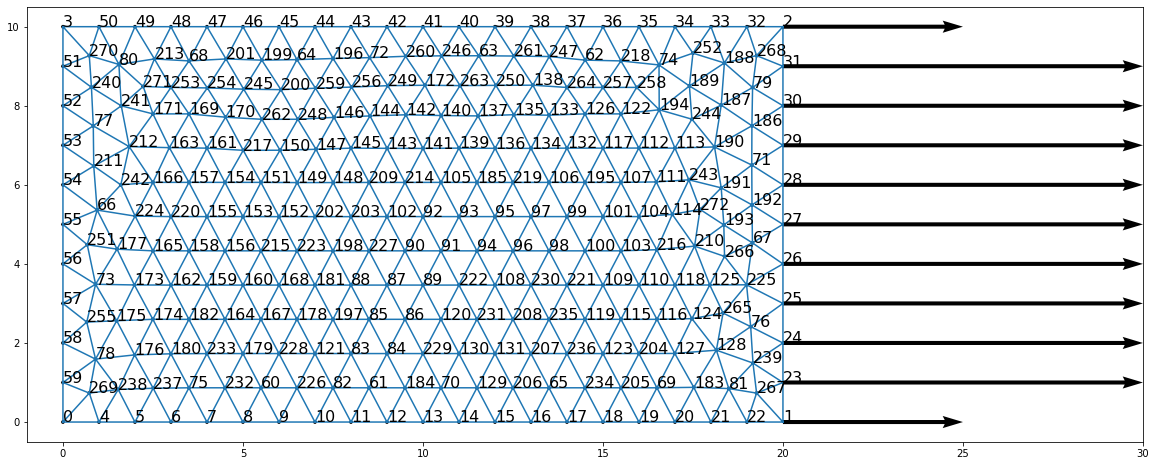

In [8]:

fig, ax = plt.subplots()

_ax = ax.triplot(MN[:,0], MN [:,1], MC)
_ax = ax.quiver(MN[:,0], MN[:,1], _FX, _FY,scale=100, units='x')
for n in range(NumeroNodos):
    ax.annotate('{:d}'.format(n), MN[n,:2], fontsize=16)
ax.set_xlim([-1,30])


In [9]:
MNE

array([[ 0,  0,  0],
       [ 3,  0,  0],
       [51,  0,  0],
       [52,  0,  0],
       [53,  0,  0],
       [54,  0,  0],
       [55,  0,  0],
       [56,  0,  0],
       [57,  0,  0],
       [58,  0,  0],
       [59,  0,  0]])

In [10]:
MN[4]

array([1., 0., 0.])

In [11]:
indexf=np.sort( np.hstack( [ 2*(NodosEmpotrados[0]-1) , 2*(NodosEmpotrados[0]-1)+1] ))#nodos a los que les conozco el desplazamiento

In [12]:
indexd = np.delete( np.arange(2*NumeroNodos) , indexf ) # nodos a los que les conozco la fuerza (si ya se, mal nombre)

In [13]:
indexf

array([  0,   1,   6,   7, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], dtype=uint64)

In [14]:
indexd

array([  2,   3,   4,   5,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,

In [15]:
# selecciono las componentes de Kglobal y resuelvo [F]=[K'][u] como [K']^-1[F]=[u] teniendo K' las componentes seleccionadas 
#segun las fuerzas conocidas desde un principio:

desplazamientos=np.dot(np.linalg.inv(kglobal[np.ix_(indexd,indexd)]),f[indexd,1])  # acordate que te falta la parte de los desplazamientos en esta ecuacion !

#creo el vector desplazamientos, la notacion es igual que en el vetor fuerzas:
#MDF_COMMENT d=np.zeros([2*n,2]) la arruine poniendo n algun contador
d = np.zeros([2*NumeroNodos,2])
d[indexd,0]=1 
d[indexd,1]=desplazamientos
f[:,1]=np.dot(kglobal,d[:,1]) # obtuve las fuerzas faltantes, paso demas

In [16]:
f[indexd,1]

array([ 5.0000e+02, -9.0949e-13,  5.0000e+02,  2.5011e-12, -2.8422e-14, -1.1369e-13, -2.2737e-13,  3.4106e-13,  3.0553e-13,
        1.7053e-13,  6.8212e-13, -1.1369e-13, -8.4555e-13,  0.0000e+00,  3.5882e-13,  3.9790e-13,  2.3914e-12,  3.4106e-13,
       -2.8990e-12,  1.1369e-13,  3.8085e-12,  4.5475e-13,  1.3727e-12,  8.5265e-13, -5.1159e-13, -1.3642e-12, -3.4674e-12,
        3.0695e-12,  2.7285e-12, -3.1832e-12,  3.1832e-12, -9.0949e-13,  4.5475e-13,  3.7517e-12,  3.7602e-12, -2.2169e-12,
        5.4996e-12, -6.8212e-13, -6.0556e-12,  2.3306e-12, -6.0254e-12,  6.5938e-12,  1.0000e+03,  5.1159e-13,  1.0000e+03,
        9.0949e-13,  1.0000e+03, -3.4106e-12,  1.0000e+03, -1.5916e-12,  1.0000e+03,  4.5546e-12,  1.0000e+03, -3.9790e-13,
        1.0000e+03, -6.7075e-12,  1.0000e+03,  5.6843e-12,  1.0000e+03, -4.3201e-12,  2.4514e-12, -1.0402e-11, -9.9476e-13,
       -9.3223e-12, -3.1868e-12, -2.2169e-12,  2.7001e-13,  2.0464e-12, -2.9412e-12, -1.9327e-12,  5.6843e-14, -7.9581e-13,
       -

In [17]:
tension=[] #np.array([])
for s in range (len(MC)) :
    i,m,j = MC[s,:]    
    index=np.array([i*2,i*2+1,j*2,j*2+1,m*2,m*2+1])
    valor=np.dot(np.dot(B[s],d[index,1]),D)
    tension.append(valor)
tension = np.array(tension)


In [18]:
tensionmax=[]
tensionmin=[]
for p in range (len(tension)):
    valor=(tension[p,0]+tension[p,1])/2+np.sqrt(((tension[p,0]-tension[p,1])/2)**2+tension[p,2]**2)
    valor2=(tension[p,0]+tension[p,1])/2-np.sqrt(((tension[p,0]-tension[p,1])/2)**2+tension[p,2]**2)

    tensionmax.append(valor)
    tensionmin.append(valor2)

tensionmax = np.array(tensionmax)
tensionmin = np.array(tensionmin)
tensionprom=(tensionmax-tensionmin)/2

In [19]:
MDFDx = d[:-1:2,1].reshape(-1,1)
MDFDy = d[1::2,1].reshape(-1,1)

In [20]:
DESP=np.hstack((MDFDx,MDFDy,np.zeros([NumeroNodos,1])))

In [21]:

desps = gmsh.view.add("desplazamientos Andres")
Desps = gmsh.view.addModelData(desps, 0, 'testeo', 'NodeData', NodeInfo[0], DESP, numComponents=3)
#en orden del argumento anterior: 
#view donde guardo los datos
#0(hace algo con el tiempo)
#nombre del modelo del mesh)
#NodeData implica que el valor que que estoy guardando esta relacionado a los nodos , puede ser NodeData,ElemenData.
#etiquetas de los nodos/elementos a los que se le asigna "desps" 
#Valores de lo que asigno
#dimension de aquello que le estoy dando como valores 

# hay una forma de poner un "video" en la visualizacion del mesh , ver script de Mariano 
# tambien hay maneras de como exportar los resultados, ver script de Mariano

In [22]:
Tensiones=gmsh.view.add('Tensiones promedio Andres')
Tensiones = gmsh.view.addModelData(Tensiones, 0, 'testeo', 'ElementData', ETAGS, tensionprom.reshape(-1,1) , numComponents=1 )

In [23]:
X, Y = np.meshgrid(MN[:,0], MN[:,1])

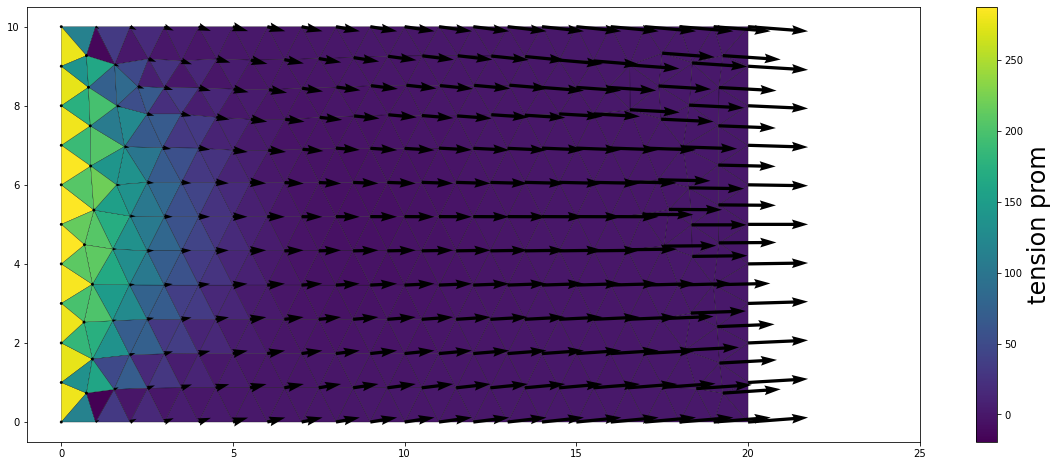

In [24]:

fig, ax = plt.subplots()
_ax =ax.tripcolor(MN[:,0], MN[:,1], MC, facecolors = tensionmin, label='$\sigma_{max}$', edgecolor='k' )
#_ax =ax.triplot(MN[:,0], MN[:,1], MC, )
ax.quiver(MN[:,0], MN[:,1], DESP[:,0], DESP[:,1], units='x', label='desplazamientos')
ax.set_xlim([-1,25])
cbar = plt.colorbar(_ax)
cbar.set_label('tension prom',fontsize=24)

In [25]:
gmsh.fltk.run()
